
## 5G NR MIB and SIB1 Recovery

Before a user equipment (UE) can communicate with a 5G base station (gNodeB), it must first find the cell (cell ID), synchronize (time and frequency) with it, and read some basic information (MIB and SIB1).


To do this, it decodes two key messages:

-  MIB (Master Information Block) \- provides fundamental parameters required to access the network.
-  SIB1 (System Information Block Type 1) \- provides additional system configuration needed for the initial connection.

This implementation shows how a 5G receiver synchronizes and decodes these messages.

### A. Transmitter Side (Signal Generation)
-  The base station periodically transmits a Synchronization Signal Block (SSB).
-  Each SSB includes \- Primary Synchronization Signal (PSS), Secondary Synchronization Signal (SSS), and Physical Broadcast Channel (PBCH) which carries the MIB.
-  The SIB1 is carried on PDSCH (Physical Downlink Shared Channel).
### B. Channel (AWGN)
-  The signal is passed through a wireless channel with Additive White Gaussian Noise (AWGN).
-  Mathematically, the received signal is: r\[n\] = x\[n\] + w\[n\], where r\[n\] = received signal, x\[n\] = transmitted signal, w\[n\] = random noise with Gaussian distribution.
### C. Receiver Side

The receiver performs the following tasks:

-  Synchronization: Aligns timing and frequency using PSS and SSS.
-  Cell Identification: Determines the cell ID (NCellID) from detected PSS/SSS.
-  Demodulation: Demodulates PBCH to obtain the MIB.
-  Decoding: Uses the MIB information to decode PDCCH, PDSCH, and finally recover SIB1.

To synchronize and demodulate the received signal, receiver needs the following parameters to process the received waveform correctly:

| **Parameter** <br>  | **Meaning** <br>  | **Purpose** <br>   |
| :-- | :-- | :-- |
| Sample Rate <br>  | Number of samples per second <br>  | Used for OFDM demodulation and timing <br>   |
| Carrier Frequency (fPhaseComp) <br>  | RF center frequency of transmission <br>  | Used to correct phase rotation in received samples <br>   |
| MinChannelBW <br>  | Minimum allowed bandwidth (5, 10, or 40 MHz) <br>  | Helps determine CORESET 0 (control region) <br>   |
| SS Block Pattern <br>  | Defines SSB frequency and subcarrier spacing (Cases A\-E) <br>  | Helps decide search range and spacing <br>   |
| L\_max <br>  | Maximum number of SS/PBCH blocks (4, 8, or 64) in SS burst <br>  | Used for PBCH DMRS and descrambling <br>   |


### A. Generate Signal containing SS burst and SIB1

First, create an SS burst containing multiple SSBs at different symbol indices. Then generate SIB1, and finally generate the waveform containing both the SS burst and SIB1.

#### **1. SS Burst**

An SS burst contains multiple SSB patterns (Case A \- Case G) depending on subcarrier spacing and carrier frequency range. It has a duration equal to half frame (5 subframe or 5 ms) and maximum number of SSBs per half frame depends on operating frequency band.

#### Generate SSB

An SSB occupies 240 subcarriers in frequency and 4 OFDM symbols in time. It is a self\-synchronization block containing PSS, SSS, PBCH, and PBCH\-DMRS, where the PBCH carries the MIB information. These components are transmitted in a specific pattern where PSS goes in first symbol SSB, SSS goes in 3rd symbol and PBCH along with DMRS goes in 2nd, 3rd, and 4th symbols.

#### Primary Synchronization Signal (PSS)




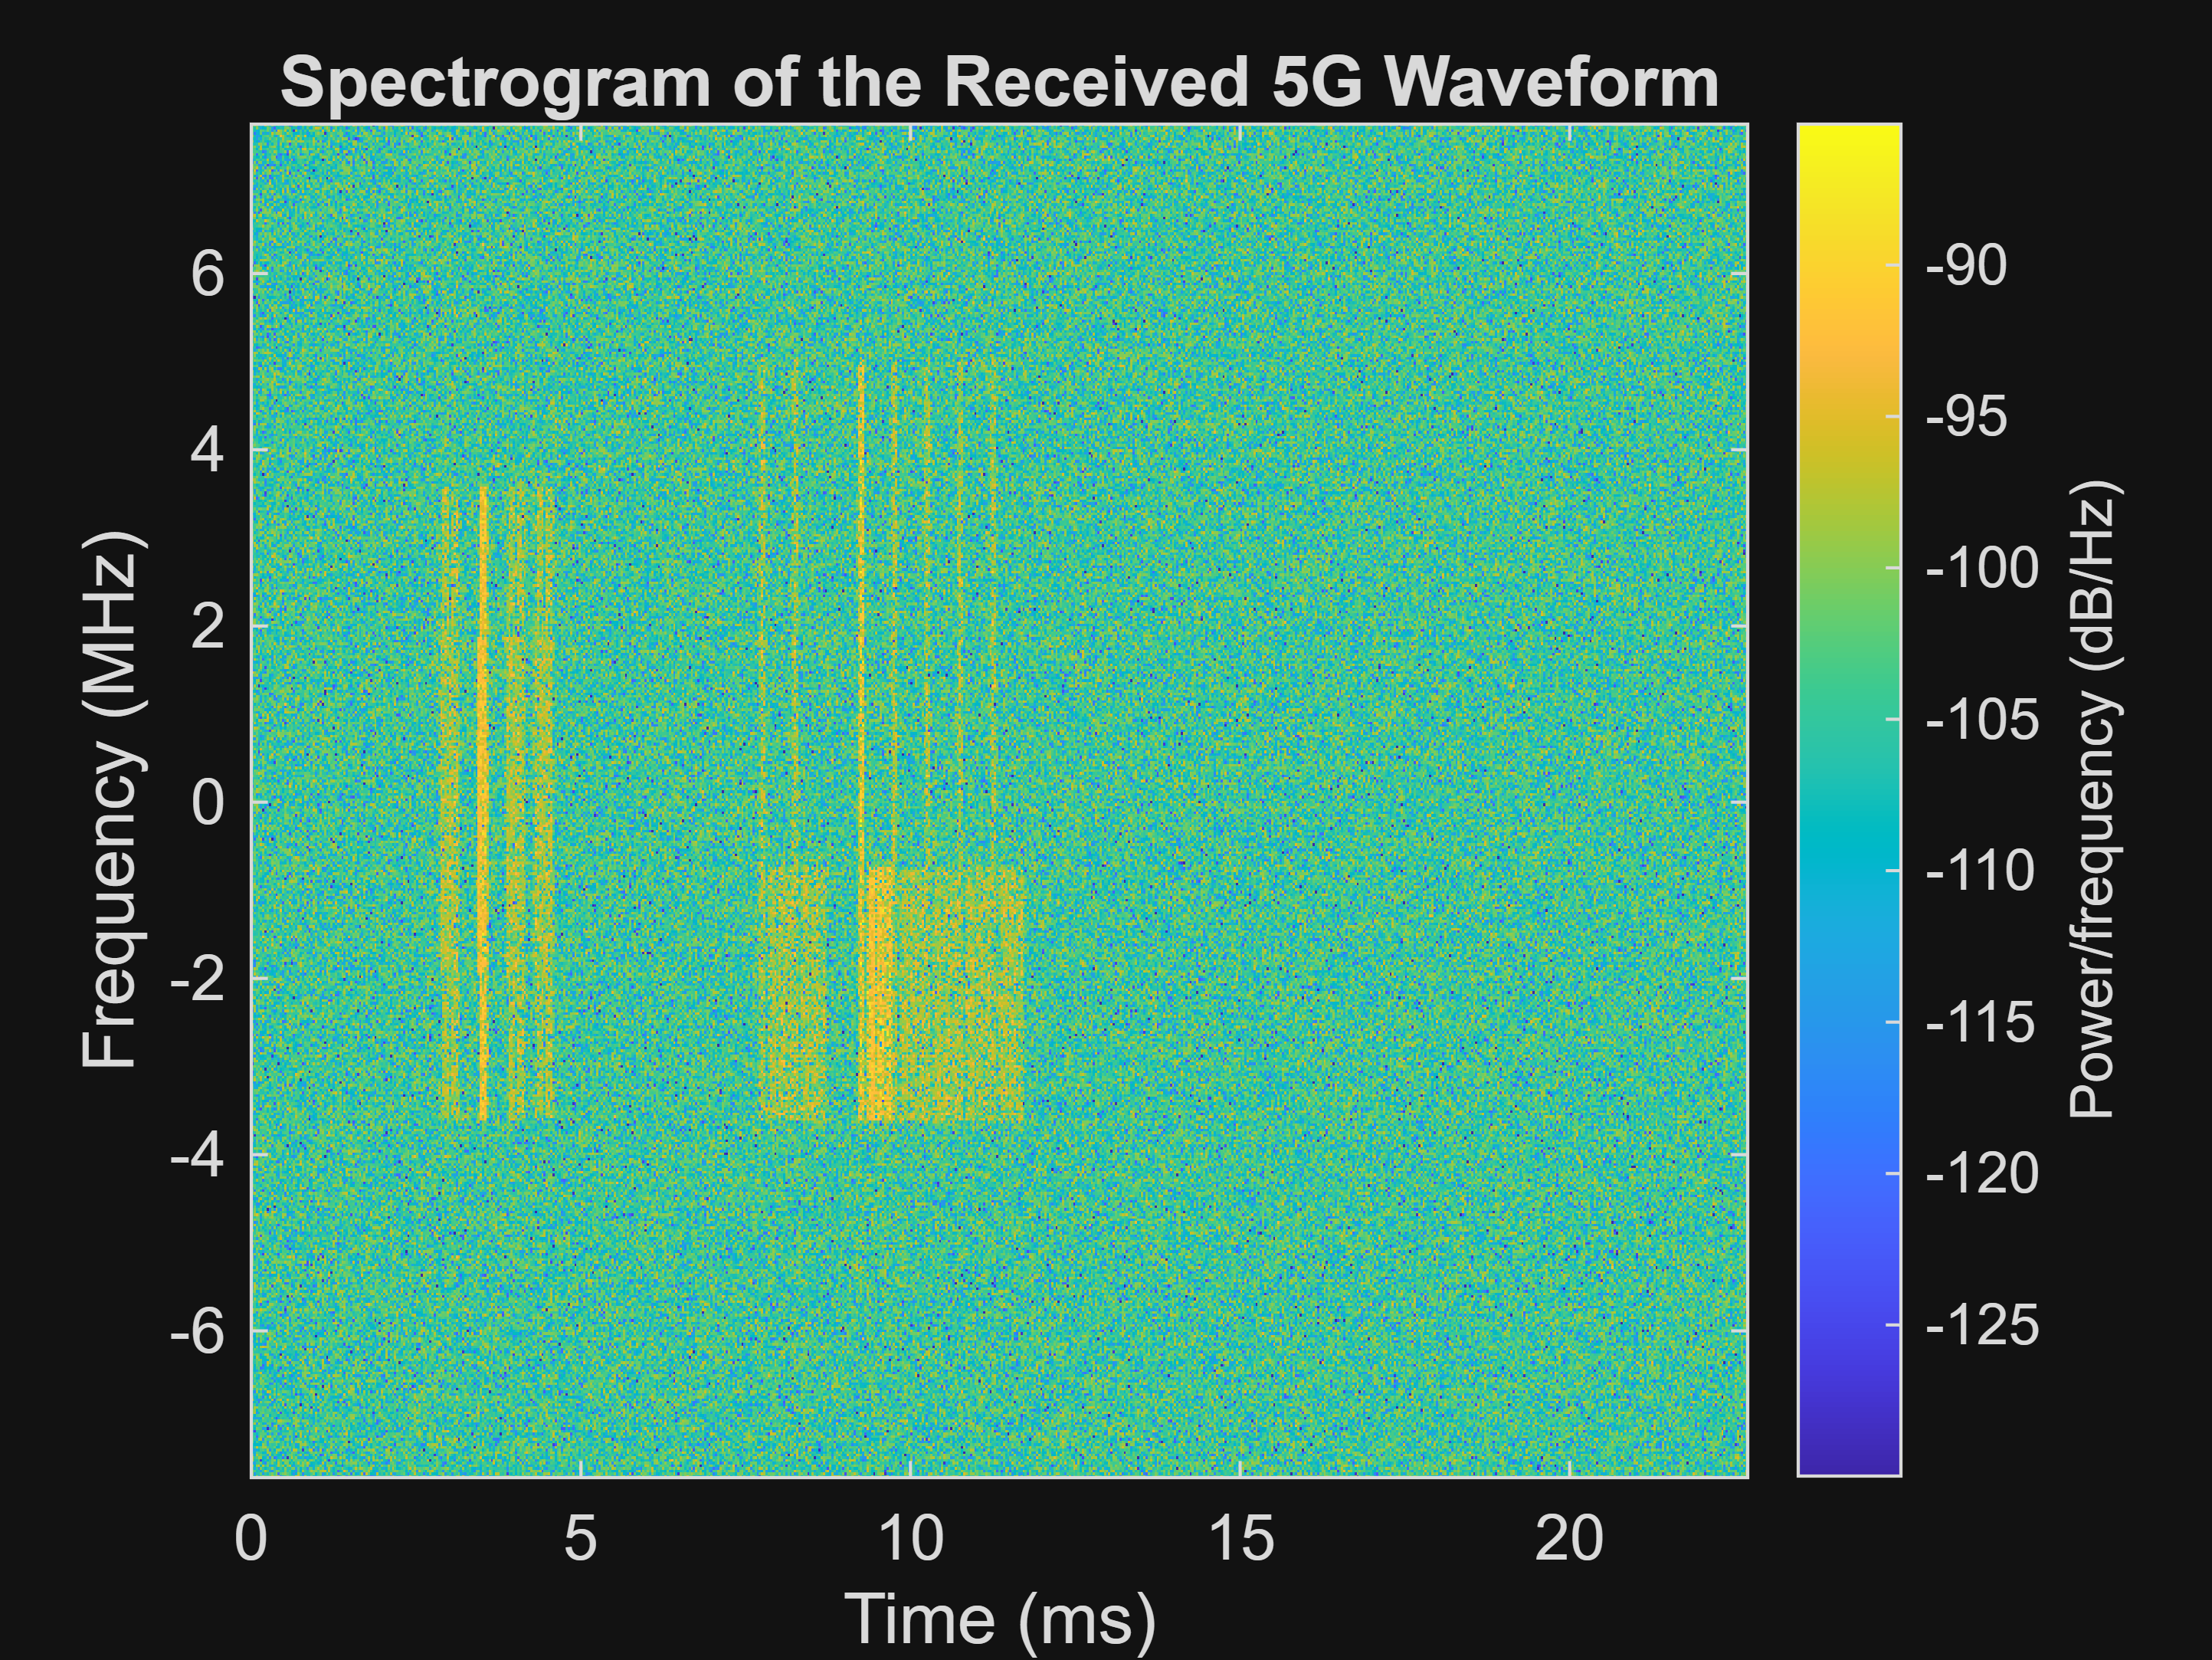

In [1]:
loadFromFile = 1; % Set to 1 to load a captured waveform

if loadFromFile

else
    % Configure the cell identity
    config = struct();
    config.NCellID = 102;

    % Configure an SS burst
    config.BlockPattern = 'Case B';         % FR1: 'Case A','Case B','Case C'. FR2: 'Case D','Case E'
    config.TransmittedBlocks = ones(1,8);   % Bitmap of SS blocks transmitted
    config.SubcarrierSpacingCommon = 15;    % SIB1 subcarrier spacing in kHz (15 or 30 for FR1. 60 or 120 for FR2)
    config.EnableSIB1 = 1;                  % Set to 0 to disable SIB1

    % Set the minimum channel bandwidth for the NR band required to
    % configure CORESET 0 in FR1 (See TS 38.101-1 Table 5.3.5-1)
    config.MinChannelBW = 5; % 5, 10, 40 MHz

    % Introduce a beamforming gain by boosting the power (and therefore
    % SNR) of one SSB and associated SIB1 PDCCH and PDSCH
    boost = 6; % SNR boost in dB
    config.Power = zeros(size(config.TransmittedBlocks));
    config.Power(1) = boost; % boost the first SSB

    % Configure and generate a waveform containing an SS burst and SIB1
    wavegenConfig = hSIB1WaveformConfiguration(config);
    [txWaveform,waveInfo] = nrWaveformGenerator(wavegenConfig);
    txOfdmInfo = waveInfo.ResourceGrids(1).Info;

    % Add white Gaussian noise to the waveform. Note that the SNR only
    % applies to the boosted SSB / SIB1
    rng('default'); % Reset the random number generator
    SNRdB = 20; % SNR for AWGN
    rxWaveform = awgn(txWaveform,SNRdB-boost,-10*log10(double(txOfdmInfo.Nfft)));

    % Configure receiver
    % Sample rate
    sampleRate = txOfdmInfo.SampleRate;

    % Symbol phase compensation frequency (Hz). The function
    % nrWaveformGenerator does not apply symbol phase compensation to the
    % generated waveform.
    fPhaseComp = 0; % Carrier center frequency (Hz)

    % Minimum channel bandwidth (MHz)
    minChannelBW = config.MinChannelBW;

    % Configure necessary burst parameters at the receiver
    refBurst.BlockPattern = config.BlockPattern;
    refBurst.L_max = numel(config.TransmittedBlocks);
end

% Get OFDM information from configured burst and receiver parameters
nrbSSB = 20;
scsSSB = hSSBurstSubcarrierSpacing(refBurst.BlockPattern);
rxOfdmInfo = nrOFDMInfo(nrbSSB,scsSSB,'SampleRate',sampleRate);

% Display spectrogram of received waveform
figure;
nfft = rxOfdmInfo.Nfft;
spectrogram(rxWaveform(:,1),ones(nfft,1),0,nfft,'centered',sampleRate,'yaxis','MinThreshold',-130);
title('Spectrogram of the Received 5G Waveform')